#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 18
**CH18 Forecasting daily ticket sales for a swimming pool**

using using swim data

version 1.0 2021-05-05

In [1]:
# Import the pandas_market_calendars module
%pip install pandas_market_calendars
import pandas_market_calendars as mcal

import os
import sys
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
from mizani.formatters import date_format
from patsy import dmatrices
from plotnine import *
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut

import seaborn as sns
import matplotlib.pyplot as plt


Note: you may need to restart the kernel to use updated packages.


### Read data

In [3]:
data = pd.read_csv("/workspaces/codespaces-jupyter/data/RC_F01_07_1992_T04_02_2025.csv", parse_dates=["date"])
#daily_agg = pd.read_csv("https://osf.io/download/jcxmk/", parse_dates=["date"])

In [4]:
data

,currency rate,date
0,125.2600,1992-07-01
1,134.8000,1992-07-03
2,130.5000,1992-07-08
3,130.3000,1992-07-10
4,130.2000,1992-07-15
...,...,...
7514,97.9658,2025-01-29
7515,98.0126,2025-01-30
7516,98.0062,2025-01-31
7517,97.8107,2025-02-01


In [5]:
data["year"] = data["date"].dt.year
data["quarter"] = data["date"].dt.quarter
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day
data["dow"] = data["date"].dt.dayofweek + 1
data["weekend"] = data["dow"].isin([6, 7])

data

,currency rate,date,year,quarter,month,day,dow,weekend
0,125.2600,1992-07-01,1992,3,7,1,3,False
1,134.8000,1992-07-03,1992,3,7,3,5,False
2,130.5000,1992-07-08,1992,3,7,8,3,False
3,130.3000,1992-07-10,1992,3,7,10,5,False
4,130.2000,1992-07-15,1992,3,7,15,3,False
...,...,...,...,...,...,...,...,...
7514,97.9658,2025-01-29,2025,1,1,29,3,False
7515,98.0126,2025-01-30,2025,1,1,30,4,False
7516,98.0062,2025-01-31,2025,1,1,31,5,False
7517,97.8107,2025-02-01,2025,1,2,1,6,True


NameError: name 'mdates' is not defined

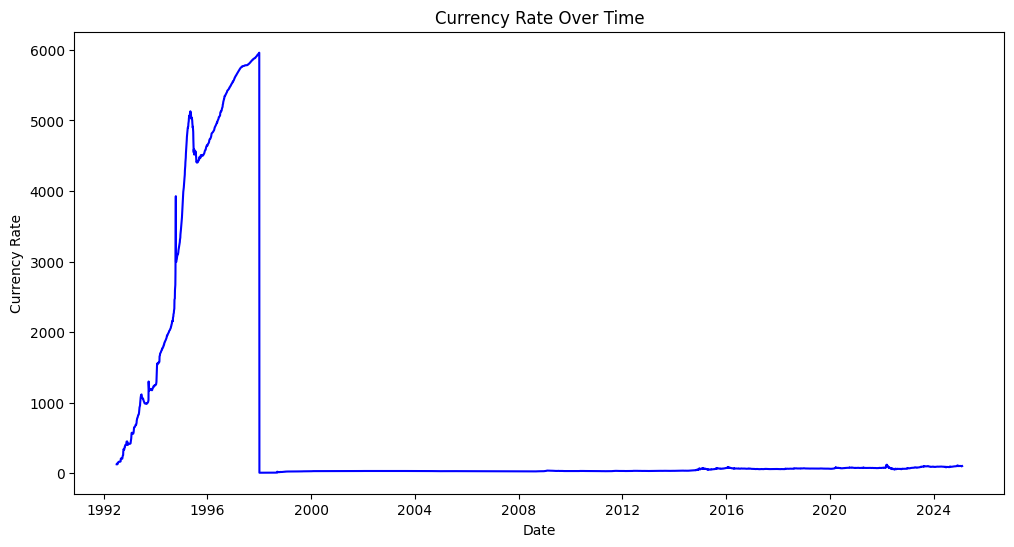

In [6]:
# Create a line plot with date on the x-axis and currency rate on the y-axis
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x="date", y="currency rate", color="blue")

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Currency Rate")
plt.title("Currency Rate Over Time")

# Format the x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())

# Add grid and show the plot
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Create a line plot with date on the x-axis and currency rate on the y-axis
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x="date", y="currency rate", color="blue")

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Currency Rate")
plt.title("Currency Rate Over Time")

# Format the x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())

# Add grid and show the plot
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [5]:
daily_agg

,date,QUANTITY,year,quarter,month,day,dow,weekend
0,2010-01-01,0,2010,1,1,1,5,False
1,2010-01-02,49,2010,1,1,2,6,True
2,2010-01-03,31,2010,1,1,3,7,True
3,2010-01-04,14,2010,1,1,4,1,False
4,2010-01-05,18,2010,1,1,5,2,False
...,...,...,...,...,...,...,...,...
2552,2016-12-27,12,2016,4,12,27,2,False
2553,2016-12-28,17,2016,4,12,28,3,False
2554,2016-12-29,27,2016,4,12,29,4,False
2555,2016-12-30,3,2016,4,12,30,5,False


In [6]:
daily_agg["school_off"] = (
    ((daily_agg["day"] > 15) & (daily_agg["month"] == 5) & (daily_agg["day"] <= 30))
    | ((daily_agg["month"] == 6) | (daily_agg["month"] == 7))
    | ((daily_agg["day"] < 15) & (daily_agg["month"] == 8))
    | ((daily_agg["day"] > 20) & (daily_agg["month"] == 12))
)

In [7]:
daily_agg["trend"] = daily_agg.index + 1

In [8]:
daily_agg

,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend
0,2010-01-01,0,2010,1,1,1,5,False,False,1
1,2010-01-02,49,2010,1,1,2,6,True,False,2
2,2010-01-03,31,2010,1,1,3,7,True,False,3
3,2010-01-04,14,2010,1,1,4,1,False,False,4
4,2010-01-05,18,2010,1,1,5,2,False,False,5
...,...,...,...,...,...,...,...,...,...,...
2552,2016-12-27,12,2016,4,12,27,2,False,True,2553
2553,2016-12-28,17,2016,4,12,28,3,False,True,2554
2554,2016-12-29,27,2016,4,12,29,4,False,True,2555
2555,2016-12-30,3,2016,4,12,30,5,False,True,2556


### Holiday Calendar

In [ ]:
nyse = mcal.get_calendar("NYSE")
holidays = nyse.holidays().holidays
daily_agg["isHoliday"] = daily_agg["date"].isin(holidays)

In [10]:
most_recent_holiday = max(holiday for holiday in holidays if holiday <= np.datetime64('today'))
most_recent_holiday

numpy.datetime64('2025-07-04')

In [13]:
daily_agg

,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend,isHoliday
0,2010-01-01,0,2010,1,1,1,5,False,False,1,True
1,2010-01-02,49,2010,1,1,2,6,True,False,2,False
2,2010-01-03,31,2010,1,1,3,7,True,False,3,False
3,2010-01-04,14,2010,1,1,4,1,False,False,4,False
4,2010-01-05,18,2010,1,1,5,2,False,False,5,False
...,...,...,...,...,...,...,...,...,...,...,...
2552,2016-12-27,12,2016,4,12,27,2,False,True,2553,False
2553,2016-12-28,17,2016,4,12,28,3,False,True,2554,False
2554,2016-12-29,27,2016,4,12,29,4,False,True,2555,False
2555,2016-12-30,3,2016,4,12,30,5,False,True,2556,False


In [15]:
daily_agg.describe(include='all')

,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend,isHoliday
count,2557,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557,2557,2557.000000,2557
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1826,1850,NaN,2493
mean,2013-07-02 00:00:00,47.867032,2013.000782,2.508408,6.522487,15.730935,4.001173,NaN,NaN,1279.000000,NaN
min,2010-01-01 00:00:00,0.000000,2010.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,NaN
25%,2011-10-02 00:00:00,14.000000,2011.000000,2.000000,4.000000,8.000000,2.000000,NaN,NaN,640.000000,NaN
50%,2013-07-02 00:00:00,28.000000,2013.000000,3.000000,7.000000,16.000000,4.000000,NaN,NaN,1279.000000,NaN
75%,2015-04-02 00:00:00,64.000000,2015.000000,4.000000,10.000000,23.000000,6.000000,NaN,NaN,1918.000000,NaN
max,2016-12-31 00:00:00,287.000000,2016.000000,4.000000,12.000000,31.000000,7.000000,NaN,NaN,2557.000000,NaN


### Define vars for analysis

In [16]:
daily_agg["q_month"] = daily_agg.groupby("month")["QUANTITY"].transform("mean")

daily_agg["QUANTITY2"] = np.where(daily_agg["QUANTITY"] < 1, 1, daily_agg["QUANTITY"])

daily_agg["q_ln"] = np.log(daily_agg["QUANTITY2"])

daily_agg["tickets"] = daily_agg.groupby(["month", "dow"])["QUANTITY"].transform("mean")

daily_agg["tickets_ln"] = daily_agg.groupby(["month", "dow"])["q_ln"].transform("mean")

daily_agg["dow_abb"] = daily_agg["date"].dt.day_name().str[:3]

daily_agg["month_abb"] = daily_agg["date"].dt.month_name().str[:3]

daily_agg


,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend,isHoliday,q_month,QUANTITY2,q_ln,tickets,tickets_ln,dow_abb,month_abb
0,2010-01-01,0,2010,1,1,1,5,False,False,1,True,21.271889,1,0.000000,5.156250,1.389561,Fri,Jan
1,2010-01-02,49,2010,1,1,2,6,True,False,2,False,21.271889,49,3.891820,36.312500,3.443075,Sat,Jan
2,2010-01-03,31,2010,1,1,3,7,True,False,3,False,21.271889,31,3.433987,39.343750,3.519238,Sun,Jan
3,2010-01-04,14,2010,1,1,4,1,False,False,4,False,21.271889,14,2.639057,16.900000,2.726322,Mon,Jan
4,2010-01-05,18,2010,1,1,5,2,False,False,5,False,21.271889,18,2.890372,16.800000,2.675239,Tue,Jan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,2016-12-27,12,2016,4,12,27,2,False,True,2553,False,15.972350,12,2.484907,14.612903,2.507322,Tue,Dec
2553,2016-12-28,17,2016,4,12,28,3,False,True,2554,False,15.972350,17,2.833213,14.903226,2.470384,Wed,Dec
2554,2016-12-29,27,2016,4,12,29,4,False,True,2555,False,15.972350,27,3.295837,13.093750,2.321463,Thu,Dec
2555,2016-12-30,3,2016,4,12,30,5,False,True,2556,False,15.972350,3,1.098612,7.096774,1.629852,Fri,Dec


In [17]:
daily_agg["year"].value_counts()

year
2012    366
2016    366
2010    365
2011    365
2013    365
2014    365
2015    365
Name: count, dtype: int64

## Prediction

### Creat train/holdout data

In [34]:
factor_cols = ["month", "dow", "isHoliday", "school_off"]
daily_agg[factor_cols] = daily_agg[factor_cols].astype("category")

data_holdout = daily_agg.loc[daily_agg["year"] == 2016, :]

data_train = daily_agg.loc[daily_agg["year"] < 2016, :]


In [20]:
factor_cols

['month', 'dow', 'isHoliday', 'school_off']

In [21]:
logo = LeaveOneGroupOut()
groups = data_train.loc[:, "year"].to_numpy()

In [23]:
groups

array([2010, 2010, 2010, ..., 2015, 2015, 2015], dtype=int32)

In [27]:
lin_reg = LinearRegression(fit_intercept=False)

In [25]:
def fit_cv_model_get_rmse(y, X, groups):
    rmse_folds = []
    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lin_reg.fit(X_train, y_train)
        y_hat = lin_reg.predict(X_test)
        rmse_folds.append(root_mean_squared_error(y_test, y_hat))

    return np.mean(rmse_folds)

## Model 0 - Linear Regression: month dummy + school off + month dummy * dow + school off * dow

In [37]:
# Model 0 linear trend + month dummy + school off + month dummy * dow + school off * dow

# training

y, X = dmatrices("QUANTITY ~ 1 + month + school_off + month * dow + school_off * dow", data_train)


rmse_reg0 = fit_cv_model_get_rmse(y, X, groups)
rmse_reg0


26.87789027644118

In [54]:
_, X_holdout = dmatrices("QUANTITY ~ 1 + month + school_off + month * dow + school_off * dow", data_holdout)
data_holdout["y_hat_0"] = lin_reg.predict(X_holdout) # prediction 
data_holdout

/tmp/ipykernel_2660/6041513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend,isHoliday,q_month,QUANTITY2,q_ln,tickets,tickets_ln,dow_abb,month_abb,y_hat_0
2191,2016-01-01,0,2016,1,1,1,5,False,False,2192,True,21.271889,1,0.000000,5.156250,1.389561,Fri,Jan,5.136364
2192,2016-01-02,16,2016,1,1,2,6,True,False,2193,False,21.271889,16,2.772589,36.312500,3.443075,Sat,Jan,36.818182
2193,2016-01-03,32,2016,1,1,3,7,True,False,2194,False,21.271889,32,3.465736,39.343750,3.519238,Sun,Jan,38.260870
2194,2016-01-04,19,2016,1,1,4,1,False,False,2195,False,21.271889,19,2.944439,16.900000,2.726322,Mon,Jan,17.863636
2195,2016-01-05,14,2016,1,1,5,2,False,False,2196,False,21.271889,14,2.639057,16.800000,2.675239,Tue,Jan,17.909091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,2016-12-27,12,2016,4,12,27,2,False,True,2553,False,15.972350,12,2.484907,14.612903,2.507322,Tue,Dec,42.695248
2553,2016-12-28,17,2016,4,12,28,3,False,True,2554,False,15.972350,17,2.833213,14.903226,2.470384,Wed,Dec,45.334921
2554,2016-12-29,27,2016,4,12,29,4,False,True,2555,False,15.972350,27,3.295837,13.093750,2.321463,Thu,Dec,43.213517
2555,2016-12-30,3,2016,4,12,30,5,False,True,2556,False,15.972350,3,1.098612,7.096774,1.629852,Fri,Dec,25.646733


In [38]:
print("Coefficients:", lin_reg.coef_)
print("Intercept:", lin_reg.intercept_)

Coefficients: [[ 1.78636364e+01 -1.61363636e+00  1.45909091e+01  1.55454545e+01
   2.98444725e+01  1.07414053e+02  6.41434904e+01  2.62842312e+01
   3.54545455e+00 -1.36363636e+00 -4.05411255e+00 -1.69678769e+01
   3.86746914e+01  4.54545455e-02  3.18181818e-01  1.36363636e-01
  -1.27272727e+01  1.89545455e+01  2.03972332e+01  1.35454545e+00
   3.13636364e+00  2.09090909e+00 -8.30211709e+00  1.10128949e+01
   1.25753831e+01  6.48539693e+00 -2.97835498e+00  2.09090909e+00
   4.17748918e-01 -4.05278429e+00 -2.34848485e-01  2.93542968e-13
   2.55844156e+00 -1.34615211e+01  1.18063950e+01 -5.19576955e+00
  -1.01047376e+00 -4.91774892e+00  1.57312253e+00 -4.13419913e-01
  -4.47675358e+00 -1.63636364e+00  3.36363636e+00 -4.59307359e+00
  -1.49942435e+01 -1.07272107e+01 -9.11193408e-01  1.07342448e+00
  -5.13636364e+00 -5.00000000e-01 -4.42207792e+00 -3.13176418e+00
   6.27272727e-01 -3.31818182e+00 -5.27272727e+00 -2.07065161e+01
  -3.44766417e+00  2.24051497e+01 -5.02395288e+00 -1.87229437e

In [55]:
# graph relative RMSE (on holdout) per month

group = data_holdout.sort_values(by=["date"]).groupby("month")
rmse_monthly = pd.DataFrame(
    {
        "date": group["date"].first(),
        "RMSE": group.apply(
            lambda x: np.sqrt(mean_squared_error(x["QUANTITY"], x["y_hat_0"]))
        ),
        "RMSE_norm": group.apply(
            lambda x: np.sqrt(mean_squared_error(x["QUANTITY"], x["y_hat_0"]))
            / np.mean(x["QUANTITY"])
        ),
    }
).reset_index(drop=True)

rmse_monthly 

/tmp/ipykernel_2660/2908338174.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_2660/2908338174.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/ipykernel_2660/2908338174.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby

,date,RMSE,RMSE_norm
0,2016-01-01,10.818982,0.480499
1,2016-02-01,12.220395,0.442436
2,2016-03-01,19.185865,0.591803
3,2016-04-01,21.176507,0.532519
4,2016-05-01,45.390762,0.732872
5,2016-06-01,36.710677,0.279878
6,2016-07-01,29.326245,0.240189
7,2016-08-01,33.835028,0.623594
8,2016-09-01,13.532540,0.510020
9,2016-10-01,17.003122,0.700927


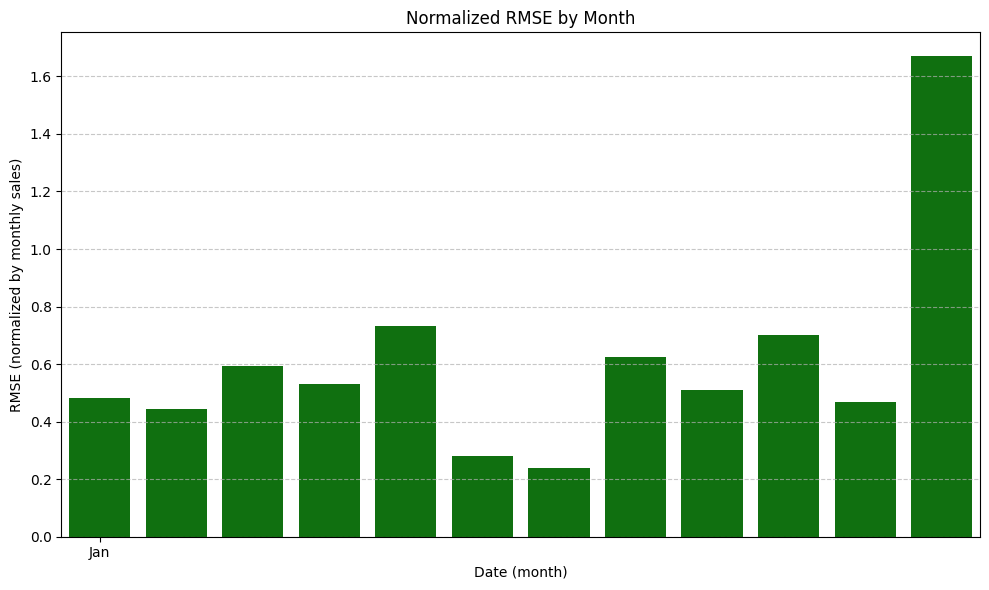

In [57]:
# Assuming `rmse_monthly` is a DataFrame with columns "date" and "RMSE_norm"
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(data=rmse_monthly, x="date", y="RMSE_norm", color="green")

# Format the x-axis to display month abbreviations
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Add labels and title
plt.xlabel("Date (month)")
plt.ylabel("RMSE (normalized by monthly sales)")
plt.title("Normalized RMSE by Month")

# Apply a grid and show the plot
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

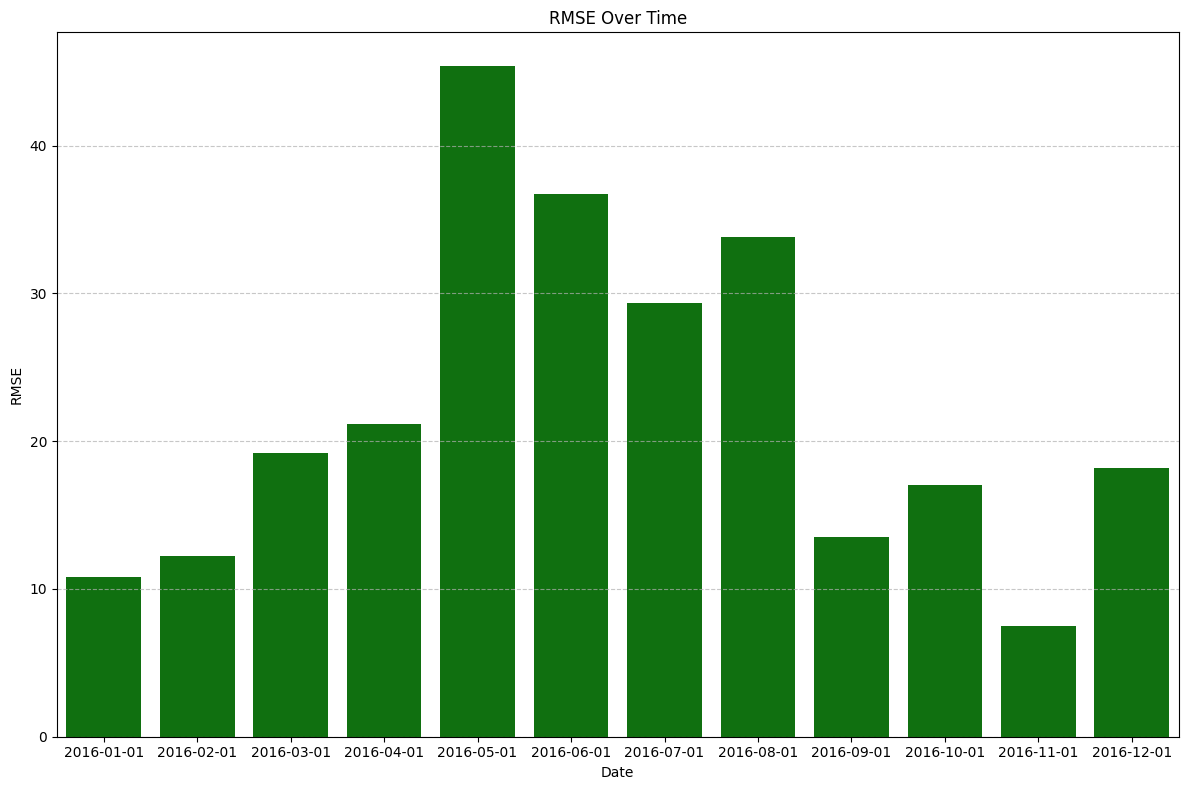

In [146]:
plt.figure(figsize=(12, 8))
sns.barplot(data=rmse_monthly, x="date", y="RMSE", color="green")
plt.xlabel("Date")
plt.ylabel("RMSE")
plt.title("RMSE Over Time")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [156]:
plotdata = (
    data_holdout.filter(["date", "month", "QUANTITY", "y_hat_0"])
    .melt(id_vars=["date", "month"])
    .merge(data_holdout.filter(["date", "QUANTITY"]), on="date")
    .merge(data_holdout.filter(["date", "y_hat_0"]), on="date")
    .rename(columns={"q_ln": "ymin", "y_hat_0": "ymax"})
)

In [157]:
plotdata

,date,month,variable,value,QUANTITY,ymax
0,2016-01-01,1,QUANTITY,0.000000,0,5.136364
1,2016-01-02,1,QUANTITY,16.000000,16,36.818182
2,2016-01-03,1,QUANTITY,32.000000,32,38.260870
3,2016-01-04,1,QUANTITY,19.000000,19,17.863636
4,2016-01-05,1,QUANTITY,14.000000,14,17.909091
...,...,...,...,...,...,...
727,2016-12-27,12,y_hat_0,42.695248,12,42.695248
728,2016-12-28,12,y_hat_0,45.334921,17,45.334921
729,2016-12-29,12,y_hat_0,43.213517,27,43.213517
730,2016-12-30,12,y_hat_0,25.646733,3,25.646733


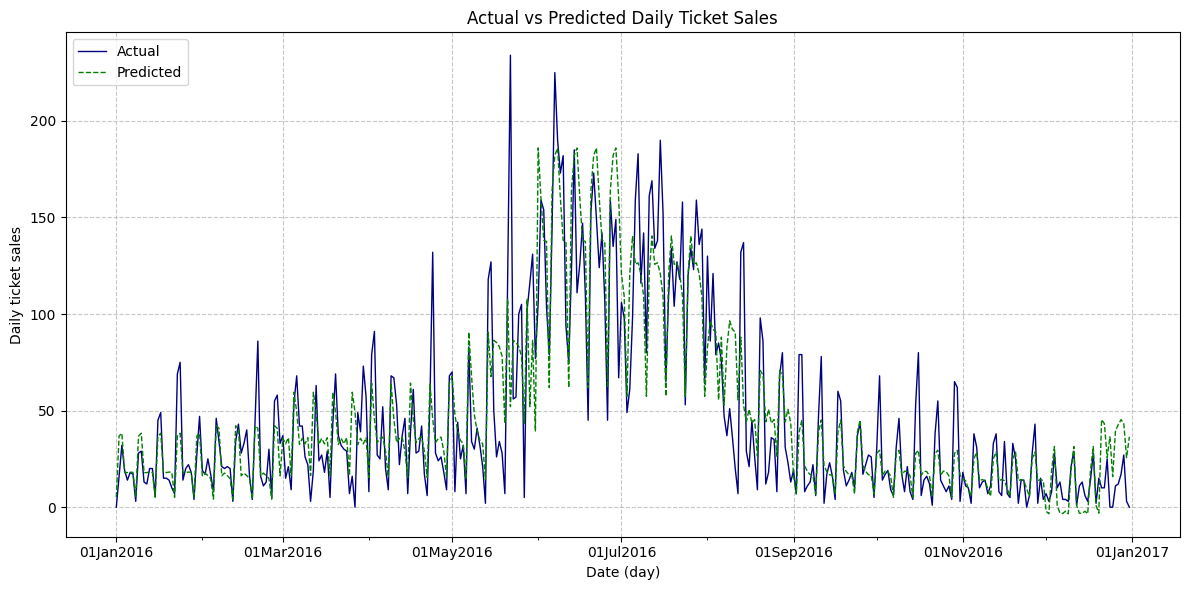

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure the 'variable' column contains the expected values
plt.figure(figsize=(12, 6))

    # Plot the actual and predicted values
sns.lineplot(
    data=plotdata[plotdata['variable'] == 'QUANTITY'],
    x='date',
    y='value',
    label='Actual',
    color='navy',
    linestyle='-',
    linewidth=1
)
sns.lineplot(
    data=plotdata[plotdata['variable'] == 'y_hat_0'],
    x='date',
    y='value',
    label='Predicted',
    color='green',
    linestyle='--',
    linewidth=1
)
    
    # Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d%b%Y"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    
    # Add labels, title, and legend
plt.xlabel("Date (day)")
plt.ylabel("Daily ticket sales")
plt.title("Actual vs Predicted Daily Ticket Sales")
plt.legend(loc="upper left")
    
    # Add grid
plt.grid(True, linestyle="--", alpha=0.7)
    
    # Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Models with ln Qantity

In [62]:
daily_agg.columns

Index(['date', 'QUANTITY', 'year', 'quarter', 'month', 'day', 'dow', 'weekend',
       'school_off', 'trend', 'isHoliday', 'q_month', 'QUANTITY2', 'q_ln',
       'tickets', 'tickets_ln', 'dow_abb', 'month_abb'],
      dtype='object')

In [68]:
data_train2 = data_train.loc[lambda x: x.QUANTITY >= 1]
groups = data_train2.loc[:, "year"].to_numpy()

In [102]:
data_train.shape

(2191, 18)

In [103]:
data_train2.shape

(2122, 18)

In [110]:
def fit_cv_model_get_rmse2(y, X, groups):
    rmse_folds2 = []

        # Step 1: Start Leave-One-Group-Out CV
    for train_index, test_index in logo.split(X, y, groups):

        # Step 2: Train on Training Data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lin_reg.fit(X_train, y_train)

        # Step 3: Predict on Test Data in Log Scale
        y_log_pred_test = lin_reg.predict(X_test)

        # Step 4: Estimate Bias Correction
        y_log_pred_train = lin_reg.predict(X_train)
        corrb = mean_squared_error(y_train, y_log_pred_train)

        # Step 5: Transform Predictions Back to Original Scale
        y_pred_test_corrected = np.exp(y_log_pred_test + corrb / 2)
        y_test_original = np.exp(y_test)


        rmse = root_mean_squared_error(y_test_original, y_pred_test_corrected)
        rmse_folds2.append(rmse)

    return np.mean(rmse_folds2)

In [ ]:
        # Step 2: Train on Training Data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lin_reg.fit(X_train, y_train)

        # Step 3: Predict on Test Data in Log Scale
        y_log_pred_test = lin_reg.predict(X_test)

        # Step 4: Estimate Bias Correction
        y_log_pred_train = lin_reg.predict(X_train)
        mse = mean_squared_error(y_train, y_log_pred_train)

        # Step 5: Transform Predictions Back to Original Scale
        y_pred_test_corrected = np.exp(y_log_pred_test + mse / 2)
        y_test_original = np.exp(y_test)


        rmse = root_mean_squared_error(y_test_original, y_pred_test_corrected)
        rmse_folds2.append(rmse)

In [117]:
y_log_pred_test[:5]

array([[3.05921345],
       [3.05941424],
       [3.05961502],
       [3.0598158 ],
       [3.06001658]])

In [118]:
y_log_pred_train[:5]

array([[2.69258413],
       [2.69278491],
       [2.69298569],
       [2.69318647],
       [2.69338726]])

In [120]:
corrb

0.6127064086581984

In [121]:
y_pred_test_corrected[:5]

array([[28.94989734],
       [28.95571056],
       [28.96152495],
       [28.96734051],
       [28.97315724]])

In [122]:
y_test_original[:5]

array([[ 6.],
       [34.],
       [32.],
       [16.],
       [11.]])

In [123]:
daily_agg["QUANTITY"].head()

0     0
1    49
2    31
3    14
4    18
Name: QUANTITY, dtype: int64

In [109]:
# Model 1 linear trend + monthly seasonality

y, X = dmatrices("q_ln ~ 1 + trend + month", data_train2)

rmse_reg1 = fit_cv_model_get_rmse2(y, X, groups)
rmse_reg1


37.33185180845498

In [124]:
# Model 2 linear trend + monthly seasonality + days of week seasonality

y, X = dmatrices("q_ln ~ 1 + trend + month + dow", data_train2)

rmse_reg2 = fit_cv_model_get_rmse2(y, X, groups)
rmse_reg2

45.933296849055296

In [125]:
# Model 3 linear trend + monthly seasonality + days of week  seasonality + holidays

y, X = dmatrices("q_ln ~ 1 + trend + month + dow + isHoliday", data_train2)

rmse_reg3 = fit_cv_model_get_rmse2(y, X, groups)
rmse_reg3

45.95083221582252

In [126]:
# Model 4 linear trend + monthly seasonality + days of week  seasonality + holidays + sch*dow

y, X = dmatrices("q_ln ~ 1 + trend + month + dow + isHoliday + school_off*dow", data_train2)

rmse_reg4 = fit_cv_model_get_rmse2(y, X, groups)
rmse_reg4

30.042356178792375

In [127]:
# Model 5 linear trend + monthly seasonality + days of week  seasonality + holidays + interactions

y, X = dmatrices("q_ln ~ 1 + trend + month + dow + isHoliday + school_off*dow+ weekend*month", data_train2)

rmse_reg5 = fit_cv_model_get_rmse2(y, X, groups)
rmse_reg5 


30.27220175745228

In [136]:
y, X = dmatrices("q_ln ~ 1 + trend + month + dow + school_off*dow", data_train2)

rmse_folds2 = []
for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lin_reg.fit(X_train, y_train)

        # Step 3: Predict on Test Data in Log Scale
        y_log_pred_test = lin_reg.predict(X_test)

        # Step 4: Estimate Bias Correction
        y_log_pred_train = lin_reg.predict(X_train)
        corrb = mean_squared_error(y_train, y_log_pred_train)

        # Step 5: Transform Predictions Back to Original Scale
        y_pred_test_corrected = np.exp(y_log_pred_test + corrb / 2)
        y_test_original = np.exp(y_test)


        rmse = root_mean_squared_error(y_test_original, y_pred_test_corrected)
        rmse_folds2.append(rmse)
# NOTE: this is different from book -- TODO: check why

rmse_reg6 = np.mean(rmse_folds2)
rmse_reg6

30.028843662314078

### Prophet Model

In [137]:
# Use prophet prediction -------------------------------------------
# add CV into prophet
# can be done with prophet: https://facebook.github.io/prophet/docs/diagnostics.html
# done but this is a different cross-validation as for the other models as it must be time-series like

# prophet -  multiplicative option -- tried but produced much worse results (~34. RMSE)

# Install the prophet package
%pip install prophet

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

Note: you may need to restart the kernel to use updated packages.


In [139]:
model_prophet = Prophet(
    seasonality_mode="additive",
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    growth="linear",
    daily_seasonality=True,
)

model_prophet = Prophet.add_country_holidays(model_prophet, "US")


In [140]:
model_prophet = Prophet.fit(
    model_prophet,
    df=data_train2[["date", "q_ln"]].rename({"date": "ds", "q_ln": "y"}, axis=1),
)

23:39:39 - cmdstanpy - INFO - Chain [1] start processing
23:39:39 - cmdstanpy - INFO - Chain [1] done processing


In [141]:
cv_pred = cross_validation(
    model_prophet, initial="365 days", period="365 days", horizon="365 days"
)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/4 [00:00<?, ?it/s]

23:39:41 - cmdstanpy - INFO - Chain [1] start processing
23:39:41 - cmdstanpy - INFO - Chain [1] done processing
23:39:41 - cmdstanpy - INFO - Chain [1] start processing
23:39:41 - cmdstanpy - INFO - Chain [1] done processing
23:39:41 - cmdstanpy - INFO - Chain [1] start processing
23:39:42 - cmdstanpy - INFO - Chain [1] done processing
23:39:42 - cmdstanpy - INFO - Chain [1] start processing
23:39:42 - cmdstanpy - INFO - Chain [1] done processing


In [142]:
# converting

import numpy as np
# from sklearn.metrics import mean_squared_error

# Get predicted ln(Q) and actual ln(Q)
df_cv = cv_pred[["ds", "yhat", "y"]].copy()

# Convert back to original scale
df_cv["yhat_orig"] = np.exp(df_cv["yhat"])
df_cv["y_orig"] = np.exp(df_cv["y"])

# Compute RMSE in original scale
rmse_prophet_cv = root_mean_squared_error(df_cv["y_orig"], df_cv["yhat_orig"])
print(rmse_prophet_cv)

45.80824537394864


In [143]:
df_cv

,ds,yhat,y,yhat_orig,y_orig
0,2012-01-02,3.266148,3.295837,26.210189,27.0
1,2012-01-03,3.241239,2.484907,25.565376,12.0
2,2012-01-04,3.166365,3.178054,23.721102,24.0
3,2012-01-05,2.993215,3.178054,19.949721,24.0
4,2012-01-06,1.999530,1.609438,7.385582,5.0
...,...,...,...,...,...
1412,2015-12-26,3.585889,3.367296,36.085409,29.0
1413,2015-12-28,3.049225,2.772589,21.098980,16.0
1414,2015-12-29,3.180145,3.465736,24.050238,32.0
1415,2015-12-30,3.158464,2.708050,23.534412,15.0


In [144]:
# Note: M6 log model rmse is slightly different from book
pd.DataFrame(
    [rmse_reg1, rmse_reg2, rmse_reg3, rmse_reg4, rmse_reg5, rmse_reg6, rmse_prophet_cv],
    ["M" + str(i) for i in range(1, 6)] + ["M6 (log)", "M7 (Prophet)"],
    columns=["RMSE"],
).round(2)


,RMSE
M1,37.33
M2,45.93
M3,45.95
M4,30.04
M5,30.27
M6 (log),30.03
M7 (Prophet),45.81


## Evaluate best model on holdout set

### Figure 18.6

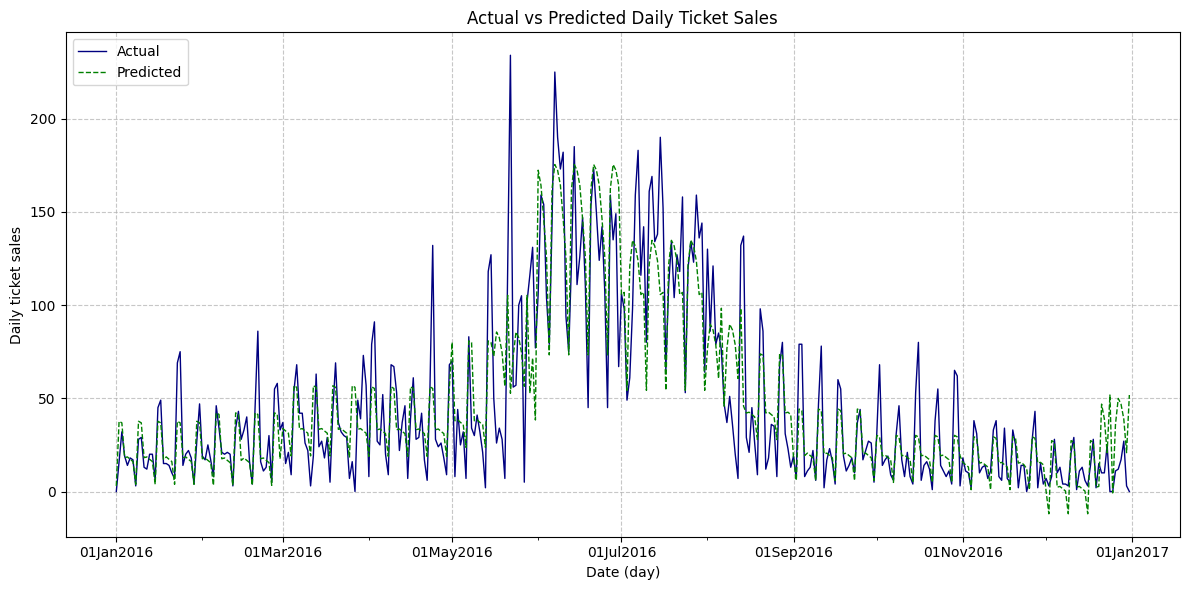

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure the 'variable' column contains the expected values
plt.figure(figsize=(12, 6))

    # Plot the actual and predicted values
sns.lineplot(
    data=plotdata[plotdata['variable'] == 'QUANTITY'],
    x='date',
    y='value',
    label='Actual',
    color='navy',
    linestyle='-',
    linewidth=1
)
sns.lineplot(
    data=plotdata[plotdata['variable'] == 'y_hat_5'],
    x='date',
    y='value',
    label='Predicted',
    color='green',
    linestyle='--',
    linewidth=1
)
    
    # Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d%b%Y"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    
    # Add labels, title, and legend
plt.xlabel("Date (day)")
plt.ylabel("Daily ticket sales")
plt.title("Actual vs Predicted Daily Ticket Sales")
plt.legend(loc="upper left")
    
    # Add grid
plt.grid(True, linestyle="--", alpha=0.7)
    
    # Adjust layout and show the plot
plt.tight_layout()
plt.show()


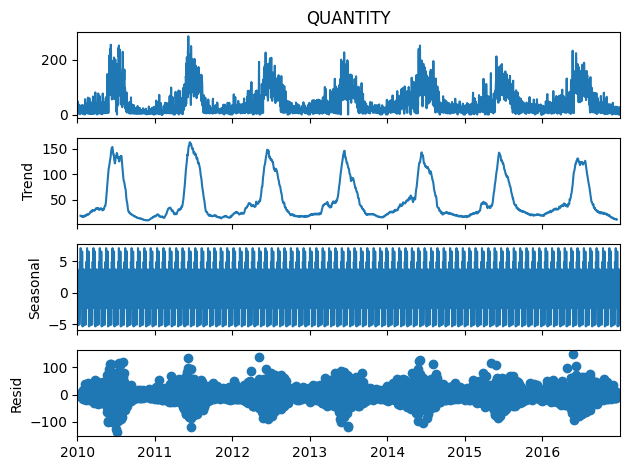

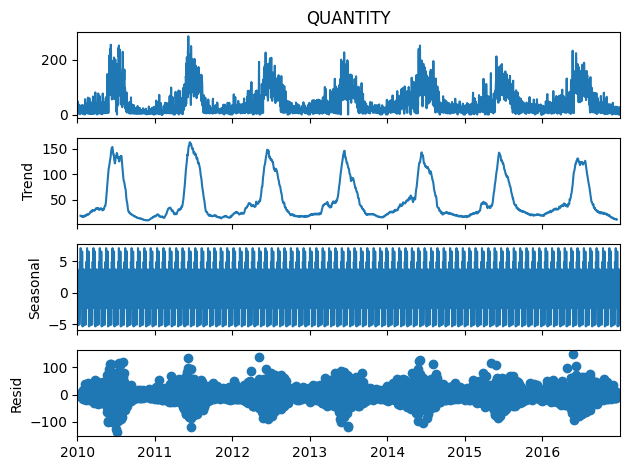

In [59]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# make sure date is datetime and set as index
daily_agg["date"] = pd.to_datetime(daily_agg["date"])
daily_agg = daily_agg.set_index("date")

# extract the series we want to analyze
series = daily_agg["QUANTITY"]

# decompose with monthly seasonality (period = 12 for monthly data)
decomp = seasonal_decompose(series, model="additive", period=30)  # 30 days ~ monthly
decomp.plot()

### Figure 18.7 a)

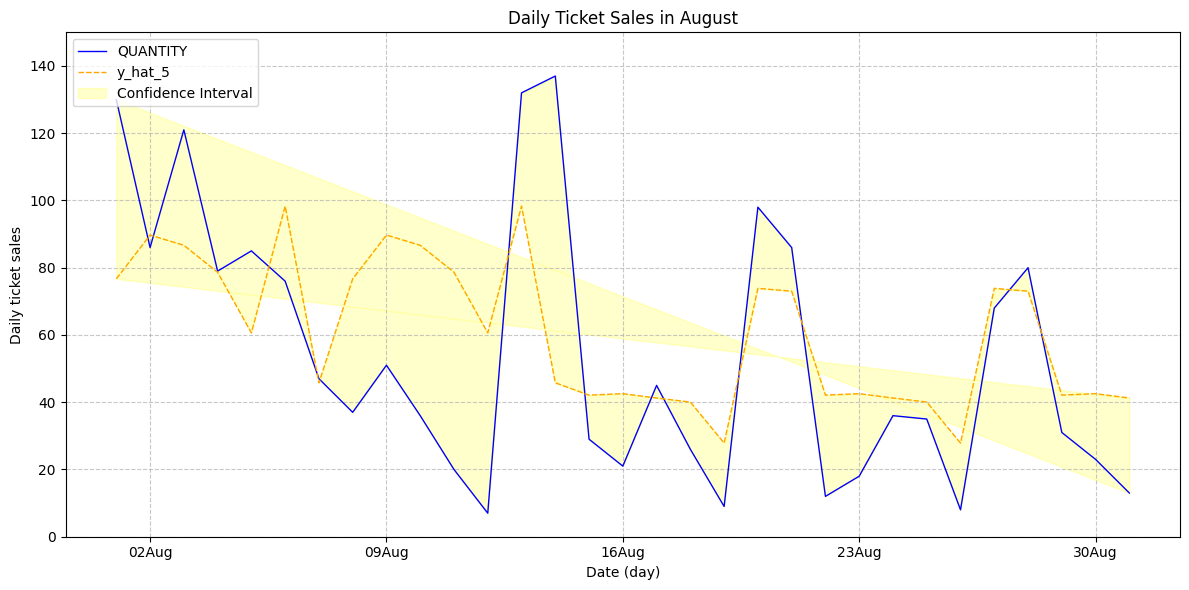

In [60]:
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filter data for August
august_data = plotdata.loc[lambda x: x["month"] == 8].reset_index()

plt.figure(figsize=(12, 6))

# Plot the actual and predicted values
sns.lineplot(
    data=august_data,
    x="date",
    y="value",
    hue="variable",
    style="variable",
    palette={"QUANTITY": "blue", "y_hat_5": "orange"},
    linewidth=1,
)

# Add ribbon for ymin and ymax
plt.fill_between(
    august_data["date"],
    august_data["ymin"],
    august_data["ymax"],
    color="yellow",
    alpha=0.2,
    label="Confidence Interval",
)

# Format the y-axis and x-axis
plt.ylim(0, 150)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d%b"))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

# Add labels, title, and legend
plt.xlabel("Date (day)")
plt.ylabel("Daily ticket sales")
plt.title("Daily Ticket Sales in August")
plt.legend(loc="upper left")

# Apply grid and show the plot
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()